**Title: The relationship between attributes of clients and their willingness on subscribing bank term deposit**

In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

**Introduction**\
----Relevant background on topic\
--------This data was gathered from a direct marketing campaign of a Portuguese baking institution.\
--------The bank collected information from their clients over the phone, and more than one contact to  the same client was required. \
----State question we are trying to answer \
--------Initial question: Which variable most influences whether or not someone will subscribe to a term deposit.\
--------Main question: Which demographic of a client is best (i.e. who is the most likely to subscribe a term deposit)\
----Identify and describe dataset\
--------The Bank Marketing Dataset discusses multiple characteristics of clients of a bank in hopes to predict whether they will subscribe to a term deposit. Variables in the set include age, job, education, marital status, and more.

**Preliminary Exploratory Data Analysis**\
----Show that dataset can be read from web into R\
--------library(tidyverse)\
--------Bank_marketing <- read_csv(“...”)\
----Put data into tidy format\
--------The data we used was already tidy when downloaded\
----Using only training data\
--------Summarize data in at least one table\
--------Visualize data with at least one plot

**Methods**\
----Explain how you’ll conduct data analysis and which variables/columns you’ll use\
--------Variables to consider: age, balance, job, education, housing loan, personal loan\
--------To perform the full analysis, a classification will be done on the data for the new observation (likeliness to subscribe to a bank term deposit) and K-nearest neighbours will be used to predict a value for the new observation.\
----Describe at least one way that you’ll visualize results\
--------Use scatter point graphs with different point colors

In [52]:
temp <- tempfile()
temp2 <- tempfile()

# Load the data from source website
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
# Read the data as csv and treat the variable "y(whether client subscribe to term deposit)" as factor
bank_data <- read_csv2(file.path(temp2, "bank.csv")) %>%
    mutate(y = as_factor(y))
unlink(c(temp, temp2))
head(bank_data)
tail(bank_data)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
32,services,single,secondary,no,473,yes,no,cellular,7,jul,624,5,-1,0,unknown,no
33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [31]:
set.seed(999)

# We choose age(client age) and balance(average yearly balance of client) as the predictors of y(whether client subscribe to term deposit),
# as we believe that these two factors affects the willingness of clients on subscribing bank term deposit the most

# Extract a data frame from the original data with only the columes that we are interested: age, balance, y
bank_age_balance <- bank_data %>%
    select(age, balance, y)

# Scale age and balance
bank_age_balance <- bank_age_balance %>%
    mutate(scaled_age = scale(age, center = TRUE),
           scaled_balance = scale(balance, center = TRUE))

# Print the head and tail of bank_age_balance
head(bank_age_balance)
tail(bank_age_balance)

age,balance,y,scaled_age,scaled_balance
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
30,1787,no,-1.0561528,0.12105847
33,4789,no,-0.7724974,1.11852057
35,1350,no,-0.5833937,-0.02414171
30,1476,no,-1.0561528,0.01772379
59,0,no,1.6858500,-0.47270062
35,747,no,-0.5833937,-0.22449803


age,balance,y,scaled_age,scaled_balance
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
32,473,no,-0.8670492,-0.31553887
33,-333,no,-0.7724974,-0.58334515
57,-3313,no,1.4967463,-1.57349741
57,295,no,1.4967463,-0.37468219
28,1137,no,-1.2452565,-0.09491434
44,1136,no,0.2675727,-0.09524661


In [33]:
# We set our seed as 999 throughout the whole project to ensure consistency of our results
set.seed(999)

# Splitting the data into training data and testing data
bank_split <- initial_split(bank_age_balance, prop = 0.75, strata = age)  
# We choose 0.75 as the portion of training data because we will perform cross-validation later,
# so the training data set cannot be too small. However we also think that the testing on
# the accuracy of our model is important, so we believe that 0.75 is an appropriate choise.
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

# Print the head and tail of the training set
head(bank_train)
tail(bank_train)

age,balance,y,scaled_age,scaled_balance
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
30,1787,no,-1.0561528,0.12105847
33,4789,no,-0.7724974,1.11852057
35,1350,no,-0.5833937,-0.02414171
30,1476,no,-1.0561528,0.01772379
59,0,no,1.6858500,-0.47270062
35,747,no,-0.5833937,-0.22449803


age,balance,y,scaled_age,scaled_balance
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
32,473,no,-0.8670492,-0.31553887
33,-333,no,-0.7724974,-0.58334515
57,-3313,no,1.4967463,-1.57349741
57,295,no,1.4967463,-0.37468219
28,1137,no,-1.2452565,-0.09491434
44,1136,no,0.2675727,-0.09524661


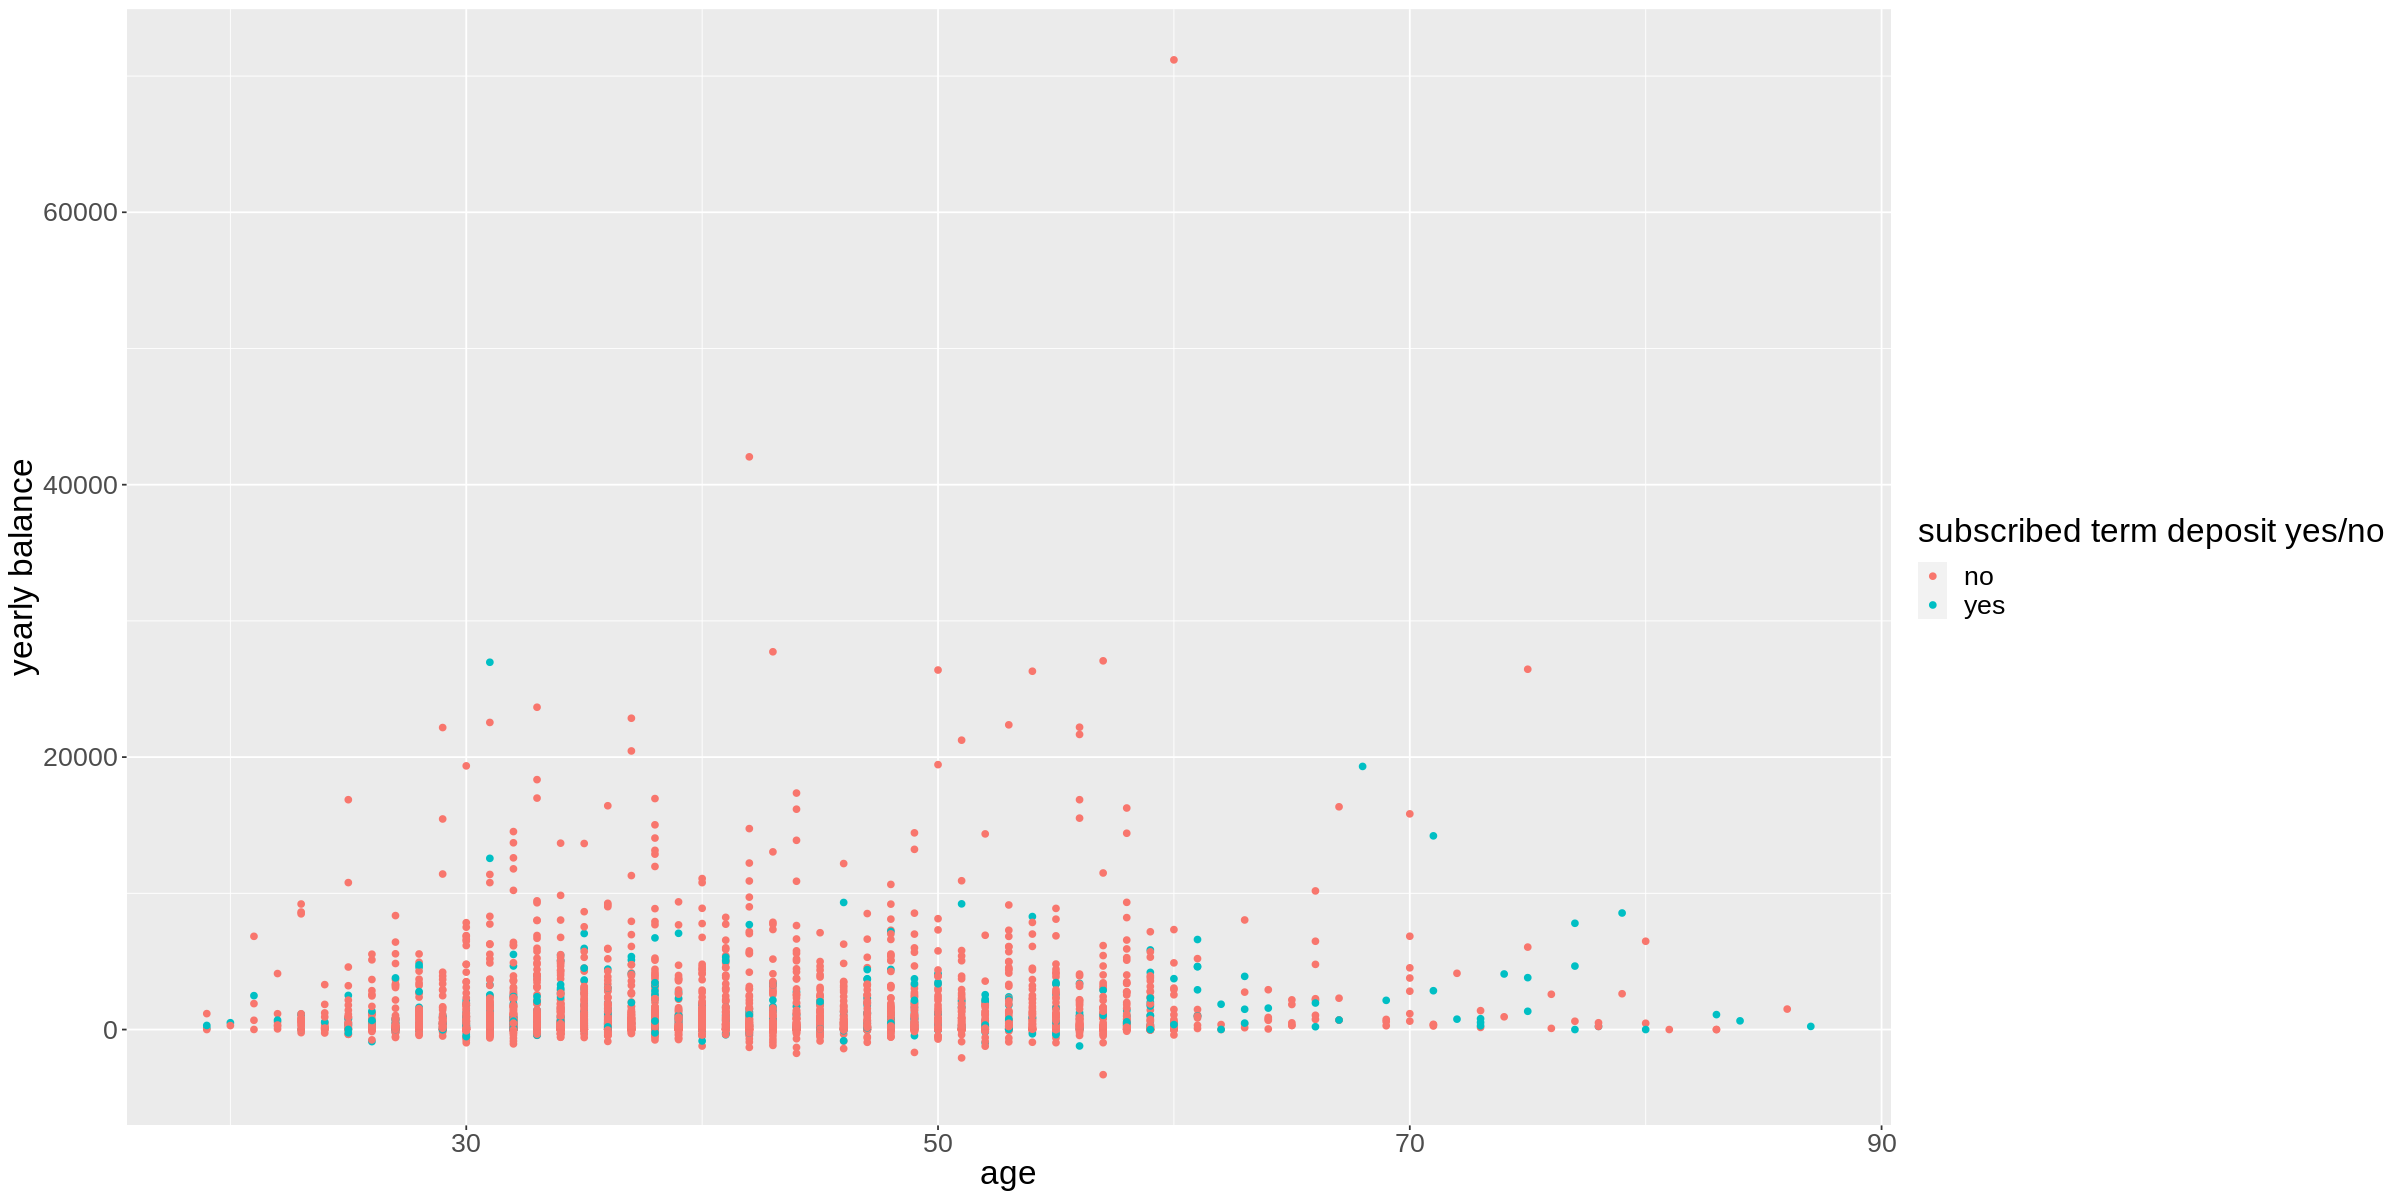

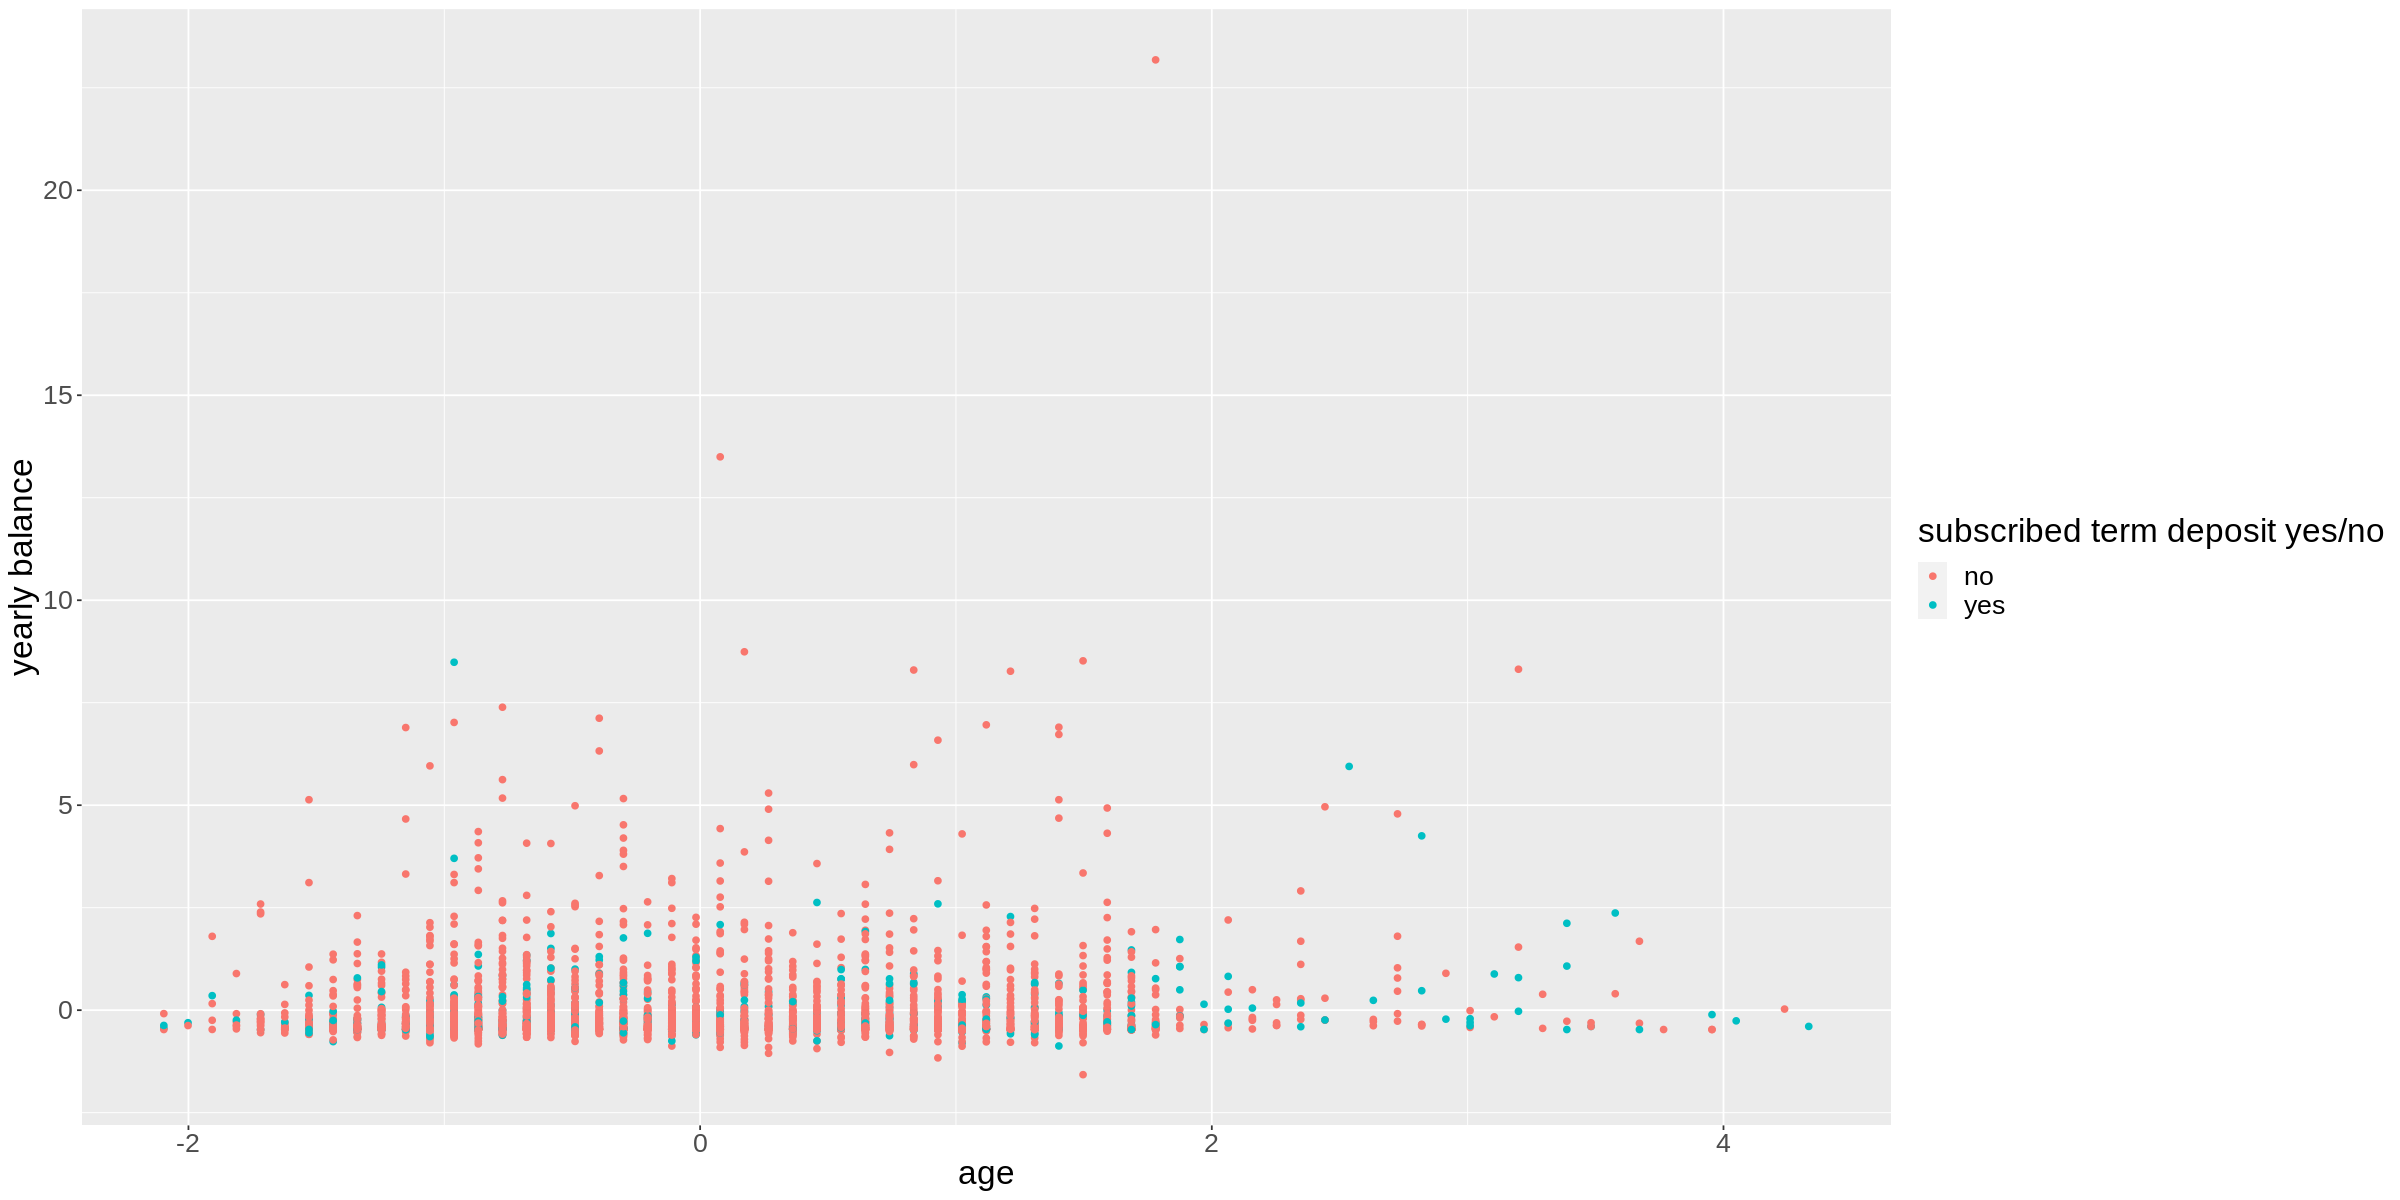

In [34]:
set.seed(999)

# We first plot a scatterplot on age vs balance and scaled_age vs scaled_balance,
# with the factor y colored on every single points.

options(repr.plot.width = 20, repr.plot.height = 10) 
age_vs_balance_plot <- bank_train %>%
    ggplot(aes(x = age, y = balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "age", y = "yearly balance",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20))
age_vs_balance_plot

scaled_age_vs_balance_plot <- bank_train %>%
    ggplot(aes(x = scaled_age, y = scaled_balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "age", y = "yearly balance",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20))
scaled_age_vs_balance_plot

In [35]:
set.seed(999)

# Create a recipe of using scaled_age and scaled_balance to predict y

bank_recipe <- recipe(y ~ scaled_age + scaled_balance, data = bank_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
bank_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [38]:
set.seed(999)

# We create our K-nearest neighbour classifier with the training set.
# Here we first randomly choose K=10 and run the process to make sure
# nothing is broken; we will perform cross-validation later and choose
# a better K value.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~10, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1149764
Best kernel: rectangular
Best k: 10

In [41]:
set.seed(999)

# We predict y for the testing set using our model of K=10
bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

# We calculate the accuracy of the model K=10, and the accuracy is 88.2%
bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

.pred_class,age,balance,y,scaled_age,scaled_balance
<fct>,<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
no,39,147,no,-0.2051864,-0.4238575
no,43,-88,no,0.1730208,-0.5019400
no,36,1109,no,-0.4888419,-0.1042178
no,37,2317,no,-0.3942901,0.2971594
no,25,-221,no,-1.5289119,-0.5461314
no,31,132,no,-0.9616010,-0.4288415


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88219663
kap,binary,0.02084081


In [55]:
set.seed(999)

# We would like to choose a better K value for our K-neighbour classification model,
# so we perform the cross-validation method on our training set.
# We choose to perform 5-fold cross-validation because 10-fold is too time consuming.
bank_vfold <- vfold_cv(bank_train, v = 5, strata = y)

# Instead of specifying a specific K value we insert tune() to keep it as a changing parameter
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_tune

# Here we perform the workflow again with cross-validation method to calculate an accuracy for
# each K value in a reasonable range, and we pick the K value that gives best accuracy
knn_results <- workflow() %>%
      add_recipe(bank_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = bank_vfold, grid = 10) %>%
      collect_metrics()
head(knn_results)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8054395,5,0.007467303,Model1
2,roc_auc,binary,0.5363620,5,0.010024752,Model1
3,accuracy,binary,0.8576058,5,0.001005625,Model2
3,roc_auc,binary,0.5417167,5,0.014828621,Model2
4,accuracy,binary,0.8567205,5,0.002073287,Model3
4,roc_auc,binary,0.5368334,5,0.015838689,Model3


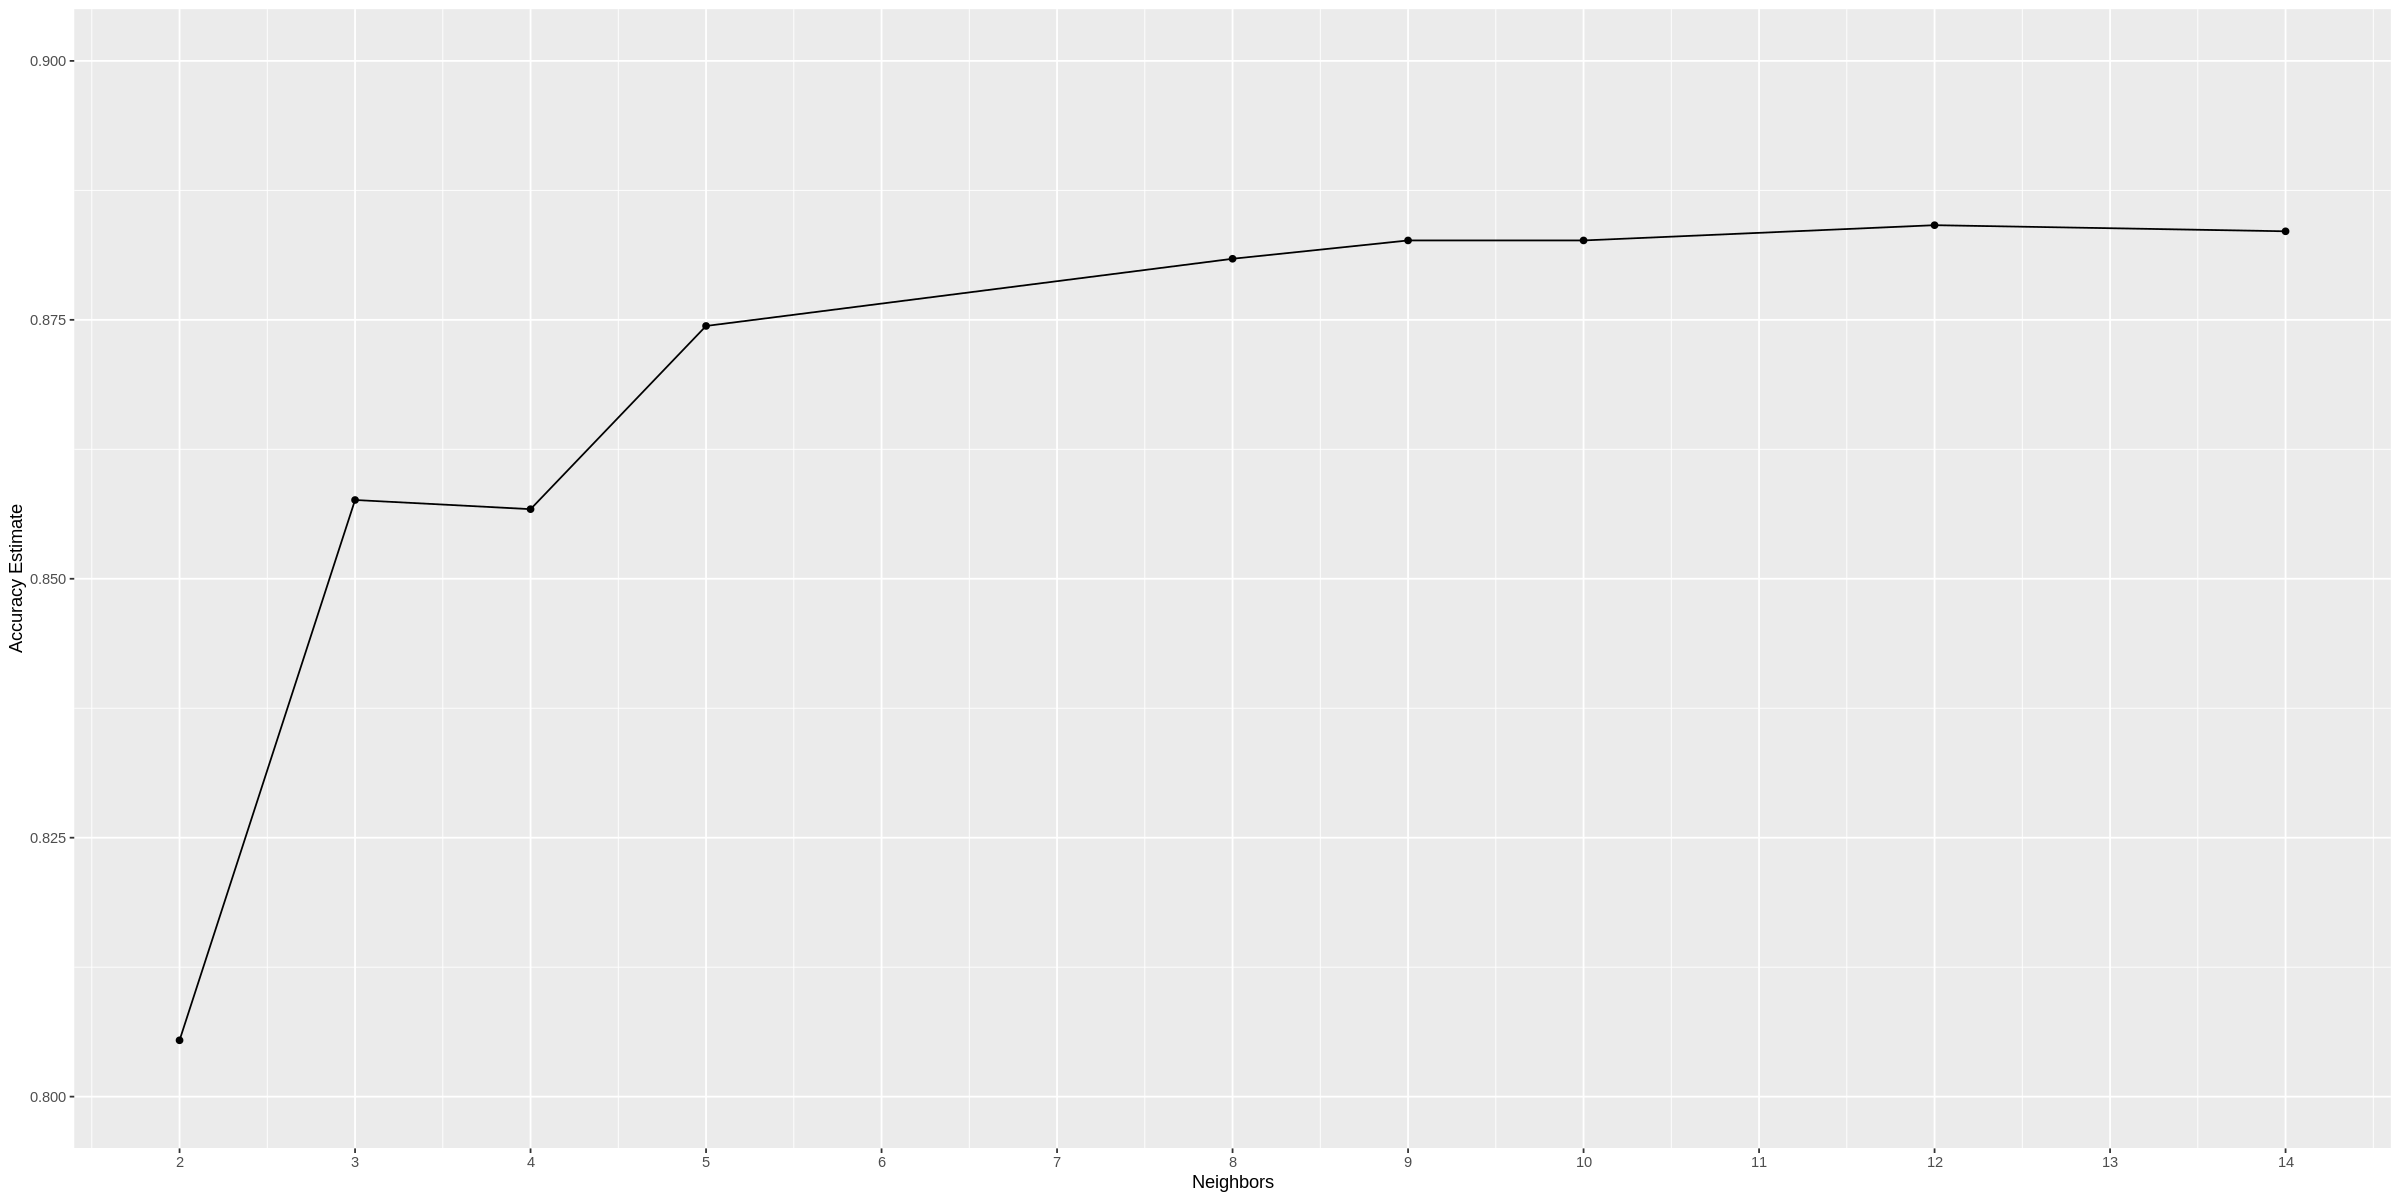

In [54]:
set.seed(999)

# Filter the accuracy from the .metric column
accuracies <- knn_results %>% 
      filter(.metric=="accuracy")

# Create a plot using the accuracies dataset with K value on the x-axis and estimated accuracy on the y-axis
options(repr.plot.width = 20, repr.plot.height = 10) 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 0.9)) # adjusting the y-axis

accuracy_versus_k

In [56]:
set.seed(999)

# From the graph above, K=12 gives the best accuracy, so we perform the whole K-neighbours classification process with K=12

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

# From bank_prediction_accuracy, our model of using age and balance to predict y have accuracy of 88.4%

.pred_class,age,balance,y,scaled_age,scaled_balance
<fct>,<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
no,39,147,no,-0.2051864,-0.4238575
no,43,-88,no,0.1730208,-0.5019400
no,36,1109,no,-0.4888419,-0.1042178
no,37,2317,no,-0.3942901,0.2971594
no,25,-221,no,-1.5289119,-0.5461314
no,31,132,no,-0.9616010,-0.4288415


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88396811
kap,binary,0.01330282


For our project we intend to plot multiple different variables in order to determine which variables are best suited to determine if someone will subscribe to a bank term deposit. The best variables will be chosen based on the relationship demonstrated on the graph. For instance, if there is a strong positive relationship on the plot then that would signify that the variable is a strong indicator of whether or not someone will subscribe to a bank term deposit. On the other hand, if there is a weak or negative relationship, then that would indicate that the variable is not suitable to determine whether or not someone will subscribe to a bank term deposit.

**Expected Outcomes & Significance**\
----What do you expect to find\
--------Use the variables we chose to predict whether a client will subscribe to a term deposit, and therefore find which variable influenced the will of a client on subscribing a term deposit the most. After finishing the model we will check our predictions with the real data to see how accurate our predictions are.\
----What impact will your findings have\
--------We can use this data to predict groups who are more interested in the bank promotion. So we can target them when the bank decides to do marketing strategy.\
----What future questions could this lead to\
--------Are there any other predicates to add for choosing the strategy?\
--------Some of predicates will disturb this data results\
--------How do different variables intersect with one another to impact whether or not someone will subscribe to a bank deposit\
--------Is there a better model to predict this data?